# Logo Similarity
This project aims to group company logos based on visual similarity. For each company, there are multiple images of its logo, and the goal is to identify and group these images according to the company they belong to. The program analyzes and organizes the logos, correctly associating each set of images with the corresponding company.

## Stages
### Stage I: Image Collection via Web Scraping
In the first stage, using the dataset `logos.snappy.parquet`, which contains the domains of multiple websites, a web scraper was implemented to collect as many images from these sites as possible. The primary goal was to identify images that could correspond to logos.

### Stage II: Feature Extraction Methods
In the second stage, the images from the dataset are loaded. Two methods are used for feature extraction: applying Principal Component Analysis (PCA) and using the deep learning model ResNet50.

### Stage III: Analysis of Unsupervised Clustering Results
In the final stage, based on the extracted features, an unsupervised clustering method was applied to group the logos based on visual similarity. The connections between the classified logos and their domains from the dataset were established. Various metrics were then used to evaluate how well the clustering correctly assigned logos belonging to the same companies. Depending on the method used, different results were obtained and compared.

***

## Stage I: Image Collection via Web Scraping

In the first stage of the project, the goal was to collect images from websites, with a special focus on identifying images that could correspond to company logos.

In [1]:
import os
import warnings
from io import BytesIO
from urllib.parse import urljoin

import requests
import urllib3
from bs4 import BeautifulSoup
from PIL import Image, UnidentifiedImageError
import pandas as pd

In [2]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.simplefilter("ignore", UserWarning)

dataset_path = './dataset/'

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    print(f"The folder '{dataset_path}' has been created.")
else:
    print(f"The folder '{dataset_path}' already exists.")

with open("logs.txt", "a") as logs_file:
    pass

df = pd.read_parquet("logos.snappy.parquet", engine="pyarrow")
domains = df['domain']
print(f"Domain has size {domains.size}.")
print(domains.head(10))

The folder './dataset/' has been created.
Domain has size 4384.
0                        stanbicbank.co.zw
1                           astrazeneca.ua
2              autosecuritas-ct-seysses.fr
3                                   ovb.ro
4    mazda-autohaus-hellwig-hoyerswerda.de
5          toyota-buchreiter-eisenstadt.at
6                                  ebay.cn
7                  greatplacetowork.com.bo
8                  wurth-international.com
9                      plameco-hannover.de
Name: domain, dtype: object


The `get_logo_from_html(domain)` function was used to extract images from the webpages of the specified domains.

### 1. Accessing URLs
The function attempts to access multiple variations of URLs for each domain to ensure that a functional URL is found:
- `https://www.{domain}`
- `http://www.{domain}`
- `https://{domain}`
- `http://{domain}`

### 2. Searching for Relevant Images
After obtaining the HTML page, the function uses **BeautifulSoup** to parse the content and search for all `<img>` tags, which contain the sources of the images. In this way, all images from the website are obtained. However, since not all images are automatically logos, a filter is applied based on the following conditions to save only the images that appear to be logos:

- **Searching within the `<header>` tag**:
  - If the image is found within a `<header>` tag, which is often used for visible sections of websites (where logos are typically located), and if the image's `alt` attribute contains the word "logo" or if the image file name contains the words "logo" or "favicon," the image is considered relevant.

- **`<link>` tags with `rel='icon'` or `rel='shortcut icon'` attributes**:
  - These tags are used to specify the site favicons, which are usually logos. These images are also added to the list of relevant images.

- **Manually adding `/favicon.ico`**:
  - By default, `/favicon.ico` is added to the list of images, as this is the standard location for favicons used by many sites.

- **Checking Image Dimensions**:
  - It is required that the dimensions of these images be smaller than 512px in both width and height, as logos typically have smaller dimensions.

### 3. Saving Images to the Dataset
Finally, only the images from the website that meet the conditions listed above are saved to the dataset.

In [3]:
def save_image(url, file_name, dataset_path):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.5615.49 Safari/537.36 Edge/112.0.1722.64',
            'Accept-Language': 'en-US,en;q=0.5',
        }

        try:
            response = requests.get(url, headers=headers, timeout=10, verify=False)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            if 'favicon.ico' not in url:
                with open("logs.txt", "a") as logs_file:
                    logs_file.write(f"Error accessing {url}: {e}\n")
            return None

        content_type = response.headers.get('Content-Type', '')
        valid_types = ['image/png', 'image/jpeg', 'image/jpg', 'image/webp', 'image/gif', 'image/x-icon', 'image/vnd.microsoft.icon']
        if content_type not in valid_types:
            return None

        image_data = BytesIO(response.content)
        try:
            image = Image.open(image_data)
            image.verify()
            image = Image.open(image_data)
        except UnidentifiedImageError:
            return None

        width, height = image.size
        if width > 512 or height > 512:
            return None

        image = image.convert("RGBA")
        file_path = os.path.join(dataset_path, file_name + ".png")
        image.save(file_path, format="PNG")

    except Exception as e:
        with open("logs.txt", "a") as logs_file:
            logs_file.write(f"Error downloading the image from {url}: {e}\n")

In [4]:
def get_logo_from_html(domain):
    response = None
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.5615.49 Safari/537.36 Edge/112.0.1722.64',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept': 'image/x-icon, image/*;q=0.8, */*;q=0.5'
        }

        urls = [
            f'https://www.{domain}',
            f'http://www.{domain}',
            f'https://{domain}',
            f'http://{domain}'
        ]

        correctUrl = ''
        for url in urls:
            headers['Referer'] = url
            response = requests.get(url, verify=False, headers=headers, timeout=10)
                    
            if response.status_code == 403:
                correctUrl = url
                break

            response.raise_for_status()
            correctUrl = url
            break

        if response is None:
            with open("logs.txt", "a") as logs_file:
                logs_file.write(f"All requests failed for {domain}\n")
            return None, []

        try:
            soup = BeautifulSoup(response.text, 'html.parser')

            found_images = []
            images = soup.find_all('img')
            for image in images:
                image_url = image.get('src')
                alt_text = image.get('alt', '').lower()
                file_name = os.path.basename(image_url) if image_url else ''

                if image.find_parent('header') and (
                    'logo' in alt_text or 
                    'logo' in file_name.lower() or 
                    'favicon' in file_name.lower()
                ):
                    found_images.append(image_url)

            link_tags = soup.find_all('link', rel='icon') + soup.find_all('link', rel='shortcut icon')
            for link in link_tags:
                found_images.append(link.get('href'))
            
            found_images.append('/favicon.ico')
            
            found_images = list(set(filter(None, found_images)))
            return correctUrl, found_images
        
        except Exception as e:
            with open("logs.txt", "a") as logs_file:
                logs_file.write(f"Parsing error for {domain}: {e}\n")
            return None, []
    except Exception as e:
        with open("logs.txt", "a") as logs_file:
            logs_file.write(f"Error processing domain {domain}: {e}\n")
        return None, []

The process was repeated for each domain in the dataset to collect as many images that appeared to be logos as possible.

In [ ]:
def scrape_from_domains(domains):
    size = len(domains)

    print(f"Starting to process {size} domains...")

    for i, domain in enumerate(domains):
        file_name = domain + '_' + str(i)

        if i % 100 == 0:
            image_count = sum([len(files) for r, d, files in os.walk(dataset_path)])
            print(f"Processing {i + 1}/{size} domains. Current image count in dataset: {image_count}")

        try:
            url, logo_urls = get_logo_from_html(domain)
            
            for j, logo_url in enumerate(logo_urls):
                logo_url = urljoin(url, logo_url)
                save_image(logo_url, f"{file_name}_{j}", dataset_path)
        except Exception as e:
            with open("logs.txt", "a") as logs_file:
                logs_file.write(f"Error processing domain {domain}: {e}\n")

    print("Processing complete. All domains have been processed.")

scrape_from_domains(domains)

### Stage II: Feature Extraction Methods

In the second stage, feature extraction from the images was performed using multiple methods in order to identify the most efficient approach.

In [5]:
import random
import textwrap

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import InterpolationMode
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

The images were loaded into a dataloader with batches of size 32, and various transformations were applied. Ten images were displayed to verify that everything went as expected.

In [6]:
class LogosDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        
        image = Image.open(image_path).convert('RGBA')
        
        r, g, b, a = image.split()
        
        image = Image.merge("RGB", (r, g, b))
        black_background = Image.new("RGB", image.size, (0, 0, 0))
        image = Image.composite(image, black_background, a)
        
        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

dataset = LogosDataset(image_folder=dataset_path, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

batches = list(dataloader)
print(f"There are {len(batches)} batches of size {batches[0][0].size()}, with a total of {len(dataset)} images.")

There are 323 batches of size torch.Size([32, 3, 128, 128]), with a total of 10308 images.


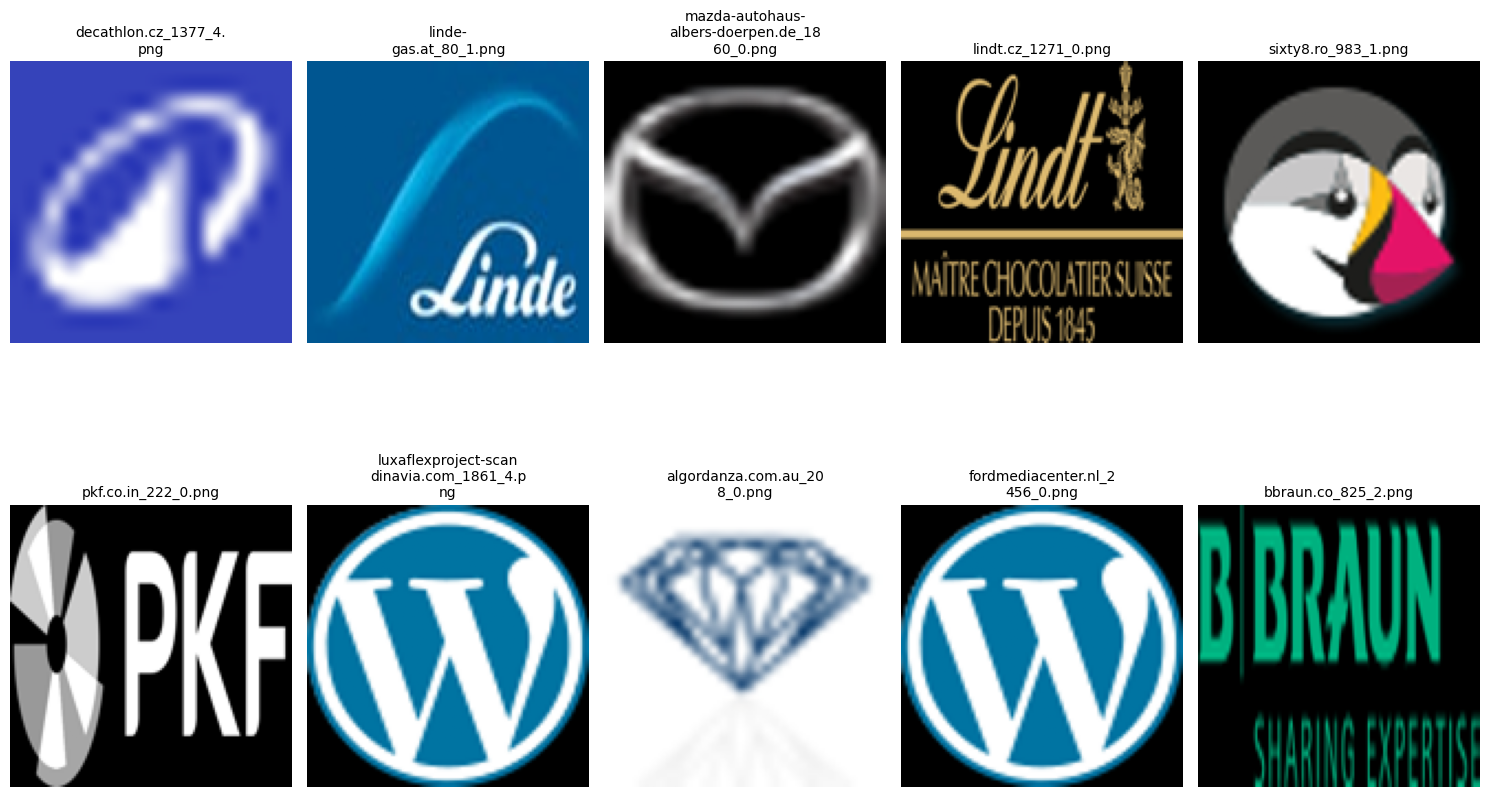

In [8]:
def show_images(dataset, num_images=10, max_title_length=20):
    num_columns = 5
    num_rows = 2
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))
    axes = axes.flatten()
    indices = random.sample(range(len(dataset)), num_images)
    
    for ax, idx in zip(axes, indices):
        image, file_name = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = (image * 0.5) + 0.5
        ax.imshow(image)
        ax.axis("off")
        
        wrapped_title = textwrap.fill(file_name, width=max_title_length)
        ax.set_title(wrapped_title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

show_images(dataset)

The first method for feature extraction was PCA. Incremental PCA was applied, using 100 components, to handle larger datasets.

In [9]:
def apply_pca(dataset, num_batches, n_components=100):
    batch_size = len(dataset) // num_batches

    ipca = IncrementalPCA(n_components=n_components)
    for i in range(0, len(dataset), batch_size):
        batch_images = []

        for j in range(i, min(i + batch_size, len(dataset))):
            image, file_name = dataset[j]
            batch_images.append(image.view(-1).numpy())

        batch_images = np.array(batch_images)
        ipca.partial_fit(batch_images) 

    reduced_images = []
    names = []

    for i in range(len(dataset)):
        image, file_name = dataset[i]
        flattened_image = image.view(-1).numpy()
        reduced_image = ipca.transform([flattened_image])
        reduced_images.append(reduced_image)
        names.append(file_name)

    reduced_images = np.array(reduced_images)
    reduced_images = np.squeeze(reduced_images)

    print("The data has been reduced to the size:", reduced_images.shape)

    return reduced_images, names

pca_images, pca_names = apply_pca(dataset, 10)

The data has been reduced to the size: (10308, 100)


The second method for feature extraction involved a pre-trained ResNet50 model. Labels were omitted since only the features were of interest. To verify correctness, various statistics were calculated, and histograms for the first five features were displayed to visualize their distribution.

In [10]:
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    image_names = []

    with torch.no_grad():
        for images, names in dataloader:
            images = images.to(device)

            if isinstance(model, models.ResNet):
                x = model.conv1(images)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)
                x = model.layer1(x)
                x = model.layer2(x)
                x = model.layer3(x)
                x = model.layer4(x)
                x = model.avgpool(x)
                outputs = x.view(x.size(0), -1)

            features.append(outputs.cpu().numpy())
            image_names.extend(names)

    features = np.vstack(features)
    print(f"{model.__class__.__name__}: {features.shape[0]} images with {features.shape[1]} features\n")
    
    print(f"Mean: {np.mean(features, axis=0)}")
    print(f"Standard deviation: {np.std(features, axis=0)}")
    print(f"Min: {np.min(features, axis=0)}")
    print(f"Max: {np.max(features, axis=0)}\n")

    print(f"{features[:5]}\n")

    images, _= next(iter(dataloader))
    fig, axes = plt.subplots(2, 5, figsize=(12, 8))
    for i in range(5):
        axes[0, i].hist(features[:, i], bins=50)
        axes[0, i].set_title(f"Feature {i+1}")
        axes[0, i].set_xlabel("Value")
        axes[0, i].set_ylabel("Frequency")

        image = images[i].cpu().permute(1, 2, 0).numpy()
        image = (image * 0.5) + 0.5

        axes[1, i].imshow(image)
        axes[1, i].axis("off")
    plt.tight_layout()
    plt.show()

    return features, image_names

Using device: cuda
GPU: NVIDIA GeForce GTX 1650

ResNet: 10308 images with 2048 features

Mean: [0.21319568 1.9578316  0.17940114 ... 0.11183425 0.07484497 0.31843275]
Standard deviation: [0.27534822 1.3775853  0.24292699 ... 0.2270839  0.27999243 0.3521031 ]
Min: [0. 0. 0. ... 0. 0. 0.]
Max: [2.6705751 6.694772  2.804187  ... 2.424533  3.3730602 4.1690435]

[[3.59074652e-01 1.35151386e+00 0.00000000e+00 ... 7.53327787e-01
  0.00000000e+00 2.61093900e-02]
 [2.00723544e-01 3.62281418e+00 6.21539950e-01 ... 0.00000000e+00
  3.34963645e-03 4.91689622e-01]
 [1.03493363e-01 1.16012383e+00 9.63082910e-02 ... 0.00000000e+00
  0.00000000e+00 6.16859719e-02]
 [2.98003037e-03 2.31155634e+00 1.08503565e-01 ... 0.00000000e+00
  2.03041673e-01 8.14094022e-02]
 [1.46536633e-01 5.64780045e+00 0.00000000e+00 ... 4.97114882e-02
  0.00000000e+00 2.15474993e-01]]



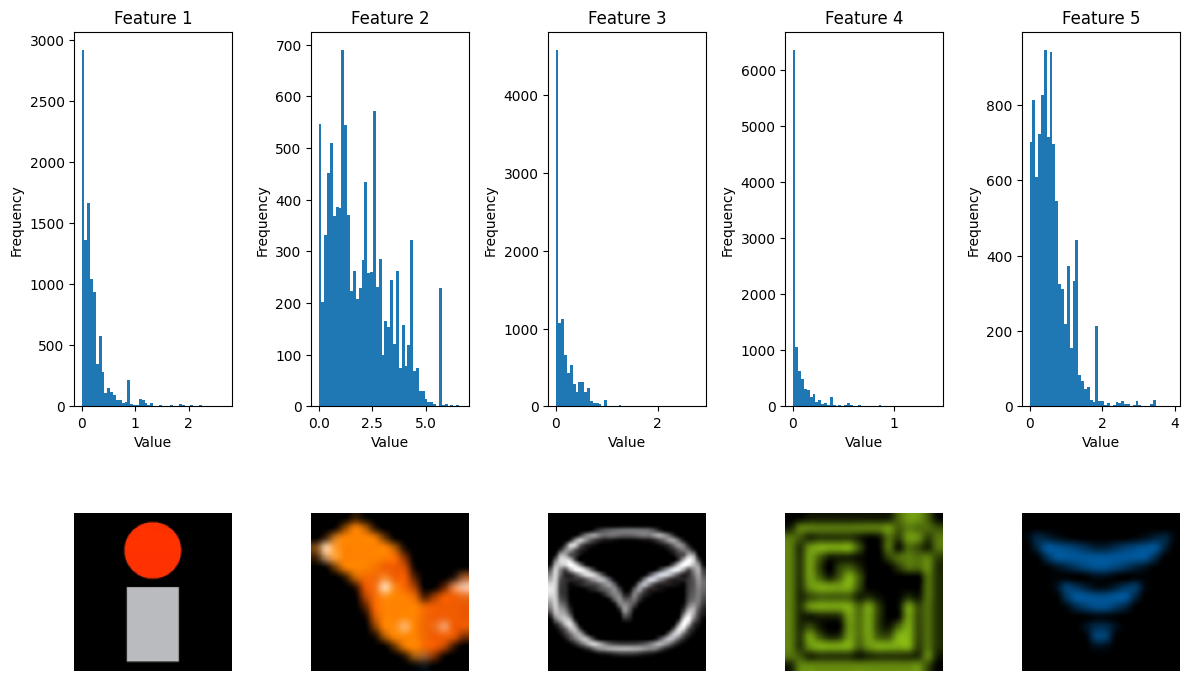

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}\n")

model = models.resnet50(pretrained=True).to(device)

feature_images, feature_names = extract_features(model, dataloader, device)

## Stage III: Analysis of Unsupervised Clustering Results

In the final stage, unsupervised clustering was applied to the previously extracted features, and different parameters were experimented with to achieve the best results.

In [12]:
import copy
import math

from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict
from sklearn.cluster import DBSCAN

First, the company names were extracted from the domain list by analyzing the common prefixes. For better understanding, we will use the following list of domains as an example:

- aamcobakersfield-unionave.com
- aamcobakersfield-whiteln.com
- aamcoflagstaff.com
- aamcofontanaca.com
- shopee.com

1. **`split_strings(strings, split='.')`**:  
   For all the domains, only the part before the "." was kept, as it contains the company names. The result will be:
   - aamcobakersfield-unionave
   - aamcobakersfield-whiteln
   - aamcoflagstaff
   - aamcofontanaca
   - shopee

2. **`find_prefixes(strings, threshold=3)`**:  
   The list was sorted, and common prefixes between the domains were identified by comparing each element with the next one. If the prefix length exceeds the specified threshold, it is added to the prefix set. The result will be:
   - aamcobakersfield-
   - aamcof
   - shopee

3. **`refine_prefixes(prefixes, strings)`**:  
   It is possible that some prefixes are included in others, so prefixes that already contain other prefixes are removed. The final result will be:
   - aamco
   - shopee

In [14]:
def split_strings(strings, split='.'):
    return [string.split(split)[0] for string in strings]

def find_prefixes(strings, threshold=3):
    strings.sort()
    prefixes = set()

    for i in range(len(strings)):
        for j in range(i + 1, len(strings)):
            prefix = os.path.commonprefix([strings[i], strings[j]])
            if len(prefix) > threshold:
                prefixes.add(prefix)

    return list(prefixes)

def refine_prefixes(prefixes, strings):
    prefixes.sort(key=len)
    refined = []

    for prefix in prefixes:
        if not any(prefix.startswith(p) for p in refined):
            refined.append(prefix)

    for string in strings:
        if not any(string.startswith(prefix) for prefix in refined):
            refined.append(string)

    return refined

Thus, the company names are obtained. For each company, a list is allocated to count how many classes it appears in and how many times.

In [15]:
def get_company_names(domains, threshold=3):
    domains = split_strings(domains)

    company_names = find_prefixes(domains, threshold)
    company_names = refine_prefixes(company_names, domains)

    return {company_name: [] for company_name in company_names}

company_names = get_company_names(domains)

print(f"{'Domain'.ljust(50)} Company Name")
random_domains = random.sample(sorted(domains), 30)
for domain in random_domains:
    matching_companies = [company_name for company_name in company_names if domain.startswith(company_name)]
    for company_name in matching_companies:
        print(f"{domain.ljust(50, '.')} {company_name}")

Domain                                             Company Name
mazdaofconshohocken.com........................... mazda
renault.dk........................................ renault
aamco-omahanorth.com.............................. aamco
aamcoeastbrunswick.com............................ aamco
bakertilly.ke..................................... bakertilly
reedglobal.com.mt................................. reedglobal
kia.pt............................................ kia
bioderma-sk.com................................... bioderma
culliganofsouthwestwisconsin.com.................. culligan
ford.dn.ua........................................ ford
toyotaortakoy.com.tr.............................. toyota
veolia.am......................................... veolia
internationalsos.no............................... inter
hertz.yt.......................................... hertz
daikineastafrica.com.............................. daikin
allianzgloballife.com............................. allianz
mart

To understand how well the classification was performed, a metric was implemented to calculate the extent to which a cluster contains logos of a single company. For better understanding, we will use the following two clusters and the images they contain as an example:

**Cluster 1:**
- toyotafocsani.ro_253_3.png
- toyota-handler.at_3237_0.png
- wwf.es_3973_0.png
- toyotahizel.com.tr_3100_2.png
- toyota-niederberger.at_2610_5.png
- yves-rocher.ch_2257_2.png
- toyota-niederberger.at_2610_4.png
- toyotaparmaksizlar.com.tr_1301_0.png

**Cluster 2:**
- europa-union-niedersachsen.de_1062_0.png
- europa-union-sachsen.de_2309_0.png
- esseskincare.hk_4129_0.png
- europa-union-sachsen-anhalt.de_37_0.png
- europa-union-thueringen.de_869_0.png

1. **`count_companies_in_label(company_names, domains)`**:  
   For each domain in the cluster, it is checked which company it belongs to. After processing all the domains, the occurrences of each company name are counted, and the number of appearances is stored. The company with the most appearances in a cluster is considered to represent that cluster. Finally, the extent to which the company is present in the cluster is calculated.  
   
     - **Toyota** is the most present in **Cluster 1**, with a proportion of **70%**:
       - toyotafocsani.ro_253_3.png
       - toyota-handler.at_3237_0.png
       - wwf.es_3973_0.png
       - toyotahizel.com.tr_3100_2.png
       - toyota-niederberger.at_2610_5.png
       - yves-rocher.ch_2257_2.png
       - toyota-niederberger.at_2610_4.png
       - toyotaparmaksizlar.com.tr_1301_0.png

     - **Europa-Union** is the most present in **Cluster 2**, with a proportion of **80%**:
       - europa-union-niedersachsen.de_1062_0.png
       - europa-union-sachsen.de_2309_0.png
       - esseskincare.hk_4129_0.png
       - europa-union-sachsen-anhalt.de_37_0.png
       - europa-union-thueringen.de_869_0.png

2. **`calculate_weighted_accuracy(company_names, clustered_data)`**:  
   A weighted accuracy is calculated to determine the accuracy over the entire dataset. The function iterates through all the clusters and obtains the accuracy for each cluster. All the obtained values are multiplied by the size of the respective cluster, and thus a global accuracy is obtained over the entire dataset, weighted according to the cluster sizes.  

   The overall accuracy for the previous example would be calculated as:
   $$
   \text{Overall Accuracy} = \frac{(0.7 \times 8) + (0.8 \times 5)}{8 + 5} = \frac{5.6 + 4}{13} = \frac{9.6}{13} \approx 0.738
   $$
   This metric gives us an insight into how well the classification was performed, and the weights take into account the size of the clusters.

In [16]:
def count_companies_in_label(company_names, domains):
    counter_companies = []
    for domain in domains:
        for company_name in company_names:
            if domain.startswith(company_name):
                counter_companies.append(company_name)

    for company_name in set(counter_companies):
        occurrences = counter_companies.count(company_name)
        company_names[company_name].append(occurrences)

    counter = Counter(counter_companies)
    most_common_company, frequency = counter.most_common(1)[0]
    percentage = (frequency / len(domains)) * 100

    return (most_common_company, percentage / 100)

def calculate_weighted_accuracy(company_names, clustered_data):
    accuracy = 0.0
    total_size = 0.0
    for label, domains in clustered_data.items():
        if label != -1:
            company_name, percentage = count_companies_in_label(company_names, domains)
            
            cluster_size = len(domains)
            
            accuracy += (percentage * cluster_size)
            total_size += cluster_size
    
    if total_size > 0:
        accuracy /= total_size
        
    return accuracy

The method described earlier is a good indicator for understanding each cluster individually, but situations can arise where the images with a company's logo are distributed across multiple clusters. For example, if we have 5 clusters that only contain the logos of the same company, the accuracy obtained earlier will be 100% because all 5 clusters contain logos from a single company. However, the issue arises because these logos are split across multiple clusters.

To understand how the logos of a company are distributed across clusters and to what extent, we will calculate entropy. In the previous steps, when calculating the accuracy, we counted and recorded how many clusters each company appears in and how many times its logos appear in each. This list of appearances can be considered as a distribution. To make it clearer, let's consider the following examples:
- **Toyota**: `[22, 2, 1]` (The images with the Toyota logo were classified into 3 clusters. One cluster contains 22 images with the Toyota logo, and the other two clusters contain 2 and 1 images, respectively.)
- **Europa-Union**: `[4, 4, 6]` (The images with the Europa-Union logo were classified into 3 clusters. One cluster contains 4 images with the Europa-Union logo, and the other two clusters contain 4 and 6 images, respectively.)

#### 1. **`calculate_entropy(distribution)`**:  
Entropy is a measure of uncertainty or disorder in a dataset. It can be calculated based on a given distribution. The formula used for calculating entropy is based on Shannon's entropy formula:
   $$
   H(X) = - \sum_{i} p_i \cdot \log_2(p_i)
   $$
Entropy quantifies the uncertainty in a distribution, where a higher entropy indicates greater uncertainty. We want to obtain the smallest possible entropy. In the ideal case, when entropy is 0, it means all images with the company's logo are classified into a single cluster.

   - For **Toyota**: `[22, 2, 1]`, the entropy is 0.64.
   - For **Europa-Union**: `[4, 4, 6]`, the entropy is 1.55. It is much higher because the elements of the distribution are more evenly split.

#### 2. **`calculate_weighted_entropy(company_names)`**:  
To obtain a global entropy, we calculate the weighted entropy. After calculating the entropy for each company (based on the distribution of its logos), a weighted average of these entropies is computed according to each company's contribution to the overall dataset. The formula for weighted entropy is:

   $$
   H_{\text{total}} = \sum_i \left( \frac{k_i}{N} \cdot H_i \right)
   $$

   - For the companies **Toyota**: `[22, 2, 1]` and **Europa-Union**: `[4, 4, 6]`, the global entropy is 0.958. Due to the fact that **Toyota** has more elements in its distribution, it has a greater influence on the final result. \

This metric provides a way to evaluate how diverse the dataset is, weighted by the size of each company's distribution.

In [17]:
def calculate_entropy(distribution):
    total = sum(distribution)
    entropy = 0

    for count in distribution:
        if count > 0:
            p = count / total
            entropy -= p * math.log(p, 2)
            
    return entropy

def calculate_weighted_entropy(company_names):
    total_elements = sum(sum(distribution) for distribution in company_names.values())
    total_entropy = 0
    for company_name, distribution in company_names.items():
        if not distribution:
            continue

        k_i = sum(distribution)
        H_i = calculate_entropy(distribution)
        p_i = k_i / total_elements
        total_entropy += p_i * H_i
        
    return total_entropy

In the final step, unsupervised clustering is applied using the **DBSCAN** algorithm. For both feature sets obtained from **PCA** and the **ResNet deep learning model**, the DBSCAN algorithm is used to classify images containing company logos.  

An important factor in the DBSCAN algorithm is the **epsilon (`eps`)** parameter, which determines the maximum distance between two points for them to be considered neighbors. The grouping of points into the same cluster depends on both the number of neighbors a point has and the value of `eps`.  

To experiment, multiple values for `eps` were tested for each feature set to analyze how the results evolved. The classification performance was evaluated using both the two previously described metrics and the **Silhouette Score**, which measures how well points are grouped within a cluster. This is done by comparing the **average distance between a point and the other points in its own cluster** with the **average distance to the nearest neighboring cluster**.  

For both the **PCA-derived** and **ResNet-generated** feature sets, the best value for the **eps** parameter among those tested was identified. Based on the three metrics calculated at each iteration, a **weighted total score** was determined for each classification corresponding to a given `eps` value. At the end, the results were displayed:
- **Graphs** illustrating the evolution of the metrics as a function of **eps**.  
- **The best eps value** identified.  
- **A few example clusters** obtained in the final classification.

In [18]:
def clustering(features, names, label_names, eps):
    copy_label_names = copy.deepcopy(label_names)

    clustering = DBSCAN(eps=eps, min_samples=1)
    labels = clustering.fit_predict(features)

    clustered_data = defaultdict(list)
    for i, label in enumerate(labels):
        clustered_data[label].append(names[i])

    if len(clustered_data) < 2:
        return None, None, None

    silhouette = silhouette_score(features, labels)
    accuracy = calculate_weighted_accuracy(copy_label_names, clustered_data)
    weighted_entropy = calculate_weighted_entropy(copy_label_names)

    return silhouette, accuracy, weighted_entropy, clustered_data

In [19]:
def get_best_eps(eps_values, silhouette_scores, accuracies, entropies, weight_silhouette=0.33, weight_accuracy=0.33, weight_entropy=0.33):
    plt.figure(figsize=(8, 5))
    plt.plot(eps_values, silhouette_scores, label='Silhouette Scores', color='blue')
    plt.title('Evolution of Silhouette Scores for different eps values')
    plt.xlabel('Eps value')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(eps_values, accuracies, label='Accuracy', color='green')
    plt.title('Evolution of Accuracy for different eps values')
    plt.xlabel('Eps value')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(eps_values, entropies, label='Entropy', color='red')
    plt.title('Evolution of Entropy for different eps values')
    plt.xlabel('Eps value')
    plt.ylabel('Entropy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    silhouette_scores_norm = (np.array(silhouette_scores) - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))
    accuracies_norm = (np.array(accuracies) - np.min(accuracies)) / (np.max(accuracies) - np.min(accuracies))
    entropies_norm = (np.max(entropies) - np.array(entropies)) / (np.max(entropies) - np.min(entropies))

    final_scores = (silhouette_scores_norm * weight_silhouette + accuracies_norm * weight_accuracy + entropies_norm * weight_entropy)
    best_index = np.argmax(final_scores)

    best_eps = eps_values[best_index]
    print(f"The ideal eps value is: {best_eps}")
    print(f"Silhouette Score: {silhouette_scores[best_index]}")
    print(f"Accuracy: {accuracies[best_index]}")
    print(f"Entropy: {entropies[best_index]}\n")

    return float(best_eps)

In [20]:
def print_clusters(clustered_data, company_names, k, n, p):
    clustered_data = {k: v for k, v in sorted(clustered_data.items(), key=lambda item: len(item[1]), reverse=True)}

    filtered_clusters = [
        (label, names) for label, names in clustered_data.items()
        if len(names) >= n and count_companies_in_label(company_names, names)[1] > p
    ]

    k = min(k, len(filtered_clusters))
    random_clusters = random.sample(filtered_clusters, k)

    print(f"Total clusters: {len(clustered_data)}")
    print(f"{k} random clusters selected from the most populated ones:")
    
    for i, (label, names) in enumerate(random_clusters, start=1):
        most_common_company, percentage = count_companies_in_label(company_names, names)
        print(f"Cluster {label} ({len(names)} items, {most_common_company} - {percentage * 100:.2f}%):")
        for name in names:
            print(f"   - {name}")
        print()

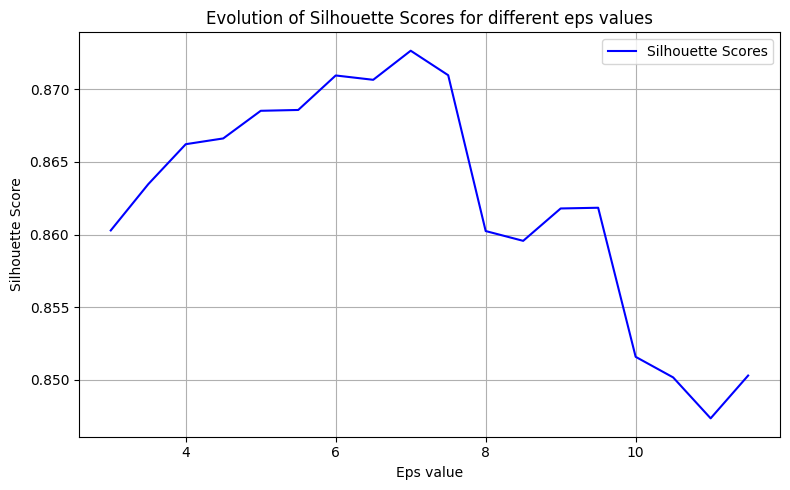

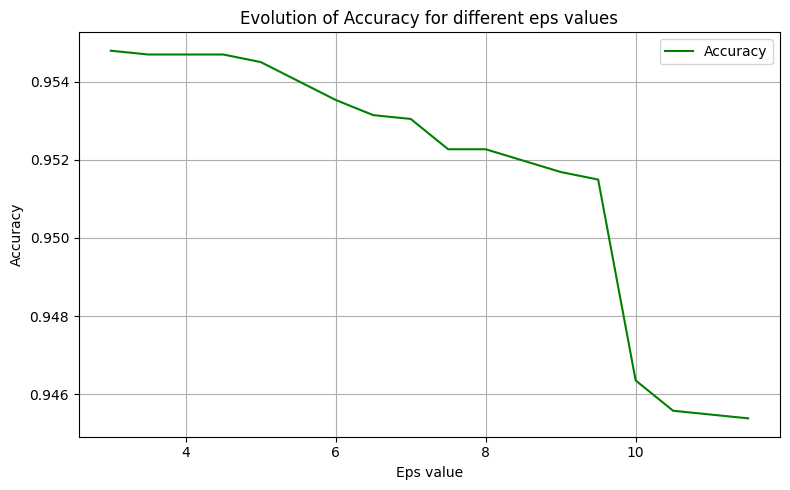

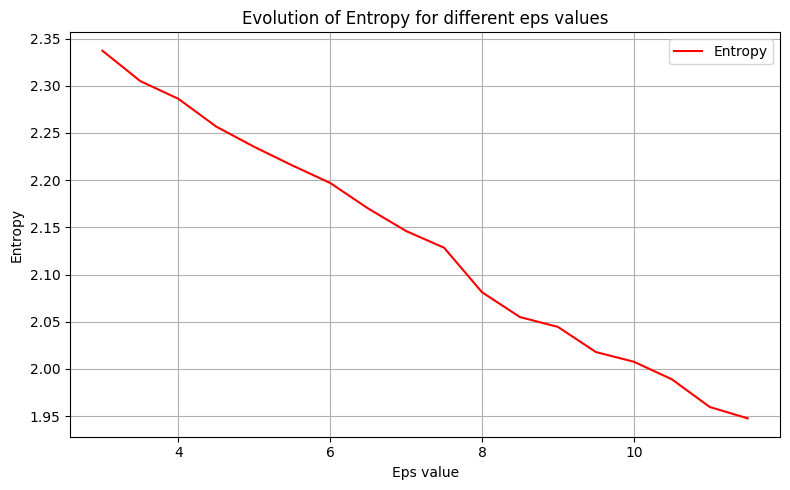

The ideal eps value is: 7.0
Silhouette Score: 0.872673684905275
Accuracy: 0.9530461777260381
Entropy: 2.1460805191306

Total clusters: 1813
5 random clusters selected from the most populated ones:
Cluster 795 (32 items, inter - 100.00%):
   - intersport-arc1950.com_239_0.png
   - intersport-arc1950.com_239_1.png
   - intersport-arc1950.com_239_3.png
   - intersport-arc1950.com_239_5.png
   - intersport-arc2000.com_2579_0.png
   - intersport-arc2000.com_2579_1.png
   - intersport-arc2000.com_2579_3.png
   - intersport-arc2000.com_2579_5.png
   - intersport-arvieux.com_971_0.png
   - intersport-arvieux.com_971_1.png
   - intersport-arvieux.com_971_3.png
   - intersport-arvieux.com_971_5.png
   - intersport-courchevel1550.com_2109_0.png
   - intersport-courchevel1550.com_2109_1.png
   - intersport-courchevel1550.com_2109_3.png
   - intersport-courchevel1550.com_2109_5.png
   - intersport-courchevel1850.com_602_0.png
   - intersport-courchevel1850.com_602_1.png
   - intersport-courchevel18

In [21]:
eps_values = np.arange(3, 12, 0.5)

accuracies = []
entropies = []
silhouette_scores = []
    
for eps in eps_values:
        silhouette_avg, accuracy, weighted_entropy, _ = clustering(pca_images, pca_names, company_names, eps)
        
        silhouette_scores.append(silhouette_avg)
        accuracies.append(accuracy)
        entropies.append(weighted_entropy)
        
best_eps = get_best_eps(eps_values, silhouette_scores, accuracies, entropies, 0.5, 0.5, 0.0)
_, _, _, clustered_data = clustering(pca_images, pca_names, company_names, eps)

print_clusters(clustered_data, company_names, 5, 25, 0.85)

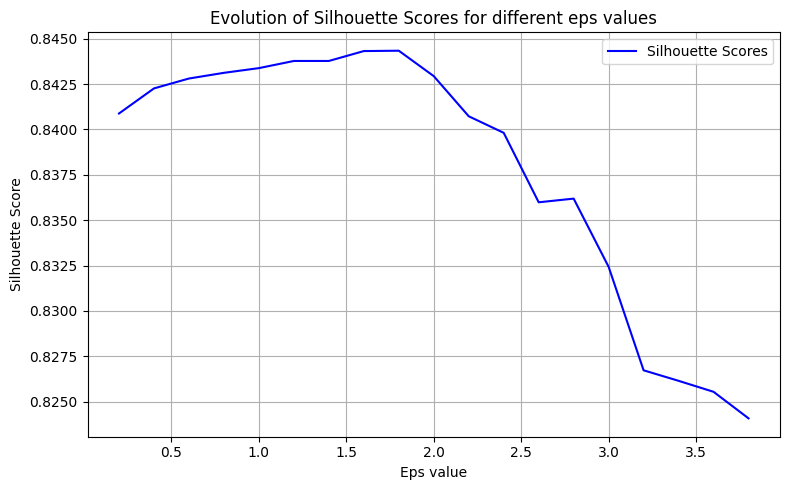

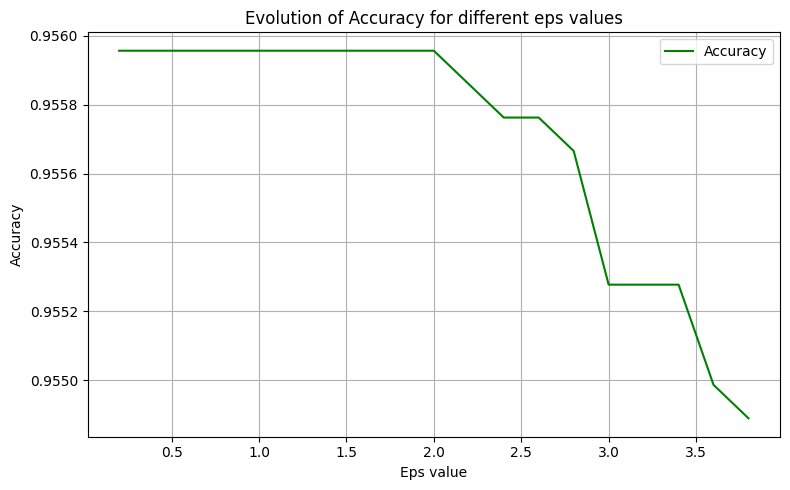

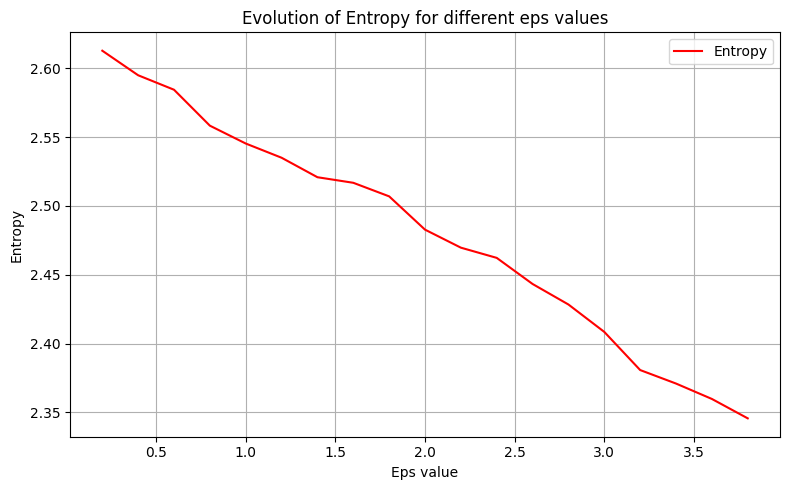

The ideal eps value is: 1.8
Silhouette Score: 0.8443374633789062
Accuracy: 0.9559565386107878
Entropy: 2.506927134881948

Total clusters: 2410
5 random clusters selected from the most populated ones:
Cluster 117 (208 items, aamco - 100.00%):
   - aamcola-culvercity.com_2751_0.png
   - aamcorochesterny.com_2369_0.png
   - aamcoeastmesa.com_389_0.png
   - aamcostuartfl.com_3487_0.png
   - aamcokellertx.com_2182_0.png
   - aamcowalnutcreekca.com_4109_0.png
   - aamcopottstownpa.com_572_0.png
   - aamcowoodbridgeva.com_949_0.png
   - aamcopennsaukennj.com_1027_0.png
   - aamcocorvallisor.com_1340_0.png
   - aamcophoenixville.com_2784_0.png
   - aamconorthridgeca.com_2472_0.png
   - aamcosalemor.com_98_0.png
   - aamcoglendaleca.com_4209_0.png
   - aamcocantonga.com_3754_0.png
   - aamcolexingtonwest.com_4142_0.png
   - aamcoburbank.com_465_0.png
   - aamcosouthtampa.com_1942_0.png
   - aamcohialeahfl.com_418_0.png
   - aamcoofupland.com_2774_0.png
   - aamcotopekaks.com_3700_0.png
   - aam

In [ ]:
eps_values = np.arange(0.2, 4, 0.2)

accuracies = []
entropies = []
silhouette_scores = []

for eps in eps_values:
        silhouette_avg, accuracy, weighted_entropy, _ = clustering(feature_images, feature_names, company_names, eps)
        
        silhouette_scores.append(silhouette_avg)
        accuracies.append(accuracy)
        entropies.append(weighted_entropy)
        
best_eps = get_best_eps(eps_values, silhouette_scores, accuracies, entropies, 0.5, 0.5, 0.0)
_, _, _, clustered_data = clustering(feature_images, feature_names, company_names, eps)

print_clusters(clustered_data, company_names, 5, 25, 0.85)